In [1]:
%matplotlib inline
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import csv

In [2]:
class reactor_sol:
  def __init__(self):   
    self.gas_mole_fracs=[]
    self.surf_fracs111=[]
    self.surf_fracs211=[]
    self.surf_fracs100=[]
    self.surf_fracs110=[]
    self.surf_fracsEdge1=[]
    self.surf_fracsEdge2=[]
    self.Ti=[]

In [28]:
def reactorCalc(n):

    #Some parameters
    T=383                                   # Initial temperature in K
    p=1                                     # pressure in bar
    volume = 0.1e-6                         # volume of the catalyst zone
    beta=20.0                               # temperature ramp in K/min
    m_cat=0.0413                            # catalyst mass in g
    cat_area = 10.4                         # m2/g 
    facet_fraction = [0.6923, 0.0439, 0.211, 0.0528, 0.0, 0.0] # [111, 211, 100, 110, edge12, edge23]
    sccm = 30.652*1e-6/60                   # Flow rate m3/s
    
    # input file containing the surface reaction mechanism
    yaml_file = 'multifacet_edge.yaml'      # Default
    #yaml_file = 'multifacet_covdep.yaml'   # Simulation with coverage dependent thermodynamics
    
    # Flag for Edge
    edge_present = n
    print(edge_present)

    # import the gas model and set the initial conditions
    gas = ct.Solution(yaml_file, 'gas')
    gas.TPX = T, p*ct.one_atm, 'Ar:1, CO2:0.0, CO:0, H2:0'

    # import the (111) surface
    surf111 = ct.Interface(yaml_file,'surface1', [gas])
    surf111.TP = T, p*ct.one_atm
    surf111.coverages = {'site(111)':1 , 'H(111)':0, 'O(111)':0, 'OC(111)':0 , 'CO2(111)':0}
    
    # import the (211) surface
    surf211 = ct.Interface(yaml_file,'surface2', [gas])
    surf211.TP = T, p*ct.one_atm
    surf211.coverages = {'site(211)':1, 'H(211)':0, 'O(211)':0, 'OC(211)':0 , 'CO2(211)':0}

    #import the (100) surface
    surf100 = ct.Interface(yaml_file,'surface3', [gas])
    surf100.TP = T, p*ct.one_atm
    surf100.coverages = {'site(100)':1, 'H(100)':0, 'O(100)':0, 'OC(100)':0 , 'CO2(100)':0}
    
    #import the (110) surface
    surf110 = ct.Interface(yaml_file,'surface4', [gas])
    surf110.TP = T, p*ct.one_atm
    surf110.coverages = {'site(110)':1, 'H(110)':0, 'O(110)':0, 'OC(110)':0 , 'CO2(110)':0}
    
    saveFileName = "noEdge_"
    # Import Edge
    if(edge_present):
            edge1 = ct.Interface(yaml_file,'edge12', [gas, surf111, surf211])
            edge1.TP = T, p*ct.one_atm
            edge2 = ct.Interface(yaml_file,'edge23', [gas, surf100, surf211])
            edge2.TP = T, p*ct.one_atm
            facet_fraction = [0.6923, 0.0439, 0.211, 0.0528, 0.0439, 0.0439] # [111, 211, 100, 110, edge12, edge23]
            # Normalize
            facet_fraction = facet_fraction/np.sum(facet_fraction)
            saveFileName = "edge_"
                
    sol = reactor_sol()
    
    # Get indices of the gas and surface species,assuming (111) and (100) have the same order of species
    sol.i_co2=gas.species_index('CO2')
    sol.i_h2=gas.species_index('H2')
    sol.i_co=gas.species_index('CO')
    sol.i_surf_Ni=surf111.species_index('site(111)')
    sol.i_surf_CO=surf111.species_index('OC(111)')
    sol.i_surf_H=surf111.species_index('H(111)')
    sol.i_surf_O=surf111.species_index('O(111)')
    sol.i_surf_C=surf111.species_index('C(111)')
    sol.i_surf_CO2=surf111.species_index('CO2(111)')    
    
    # Cantera setup
    upstream = ct.Reservoir(gas, name='upstream')
    downstream = ct.Reservoir(gas, name='downstream')
    
    r=ct.IdealGasReactor(gas, energy='off')
    r.volume=volume
    rsurf111=ct.ReactorSurface(surf111, r, A=facet_fraction[0]*cat_area*m_cat)
    rsurf211=ct.ReactorSurface(surf211, r, A=facet_fraction[1]*cat_area*m_cat)
    rsurf100=ct.ReactorSurface(surf100, r, A=facet_fraction[2]*cat_area*m_cat)
    rsurf110=ct.ReactorSurface(surf110, r, A=facet_fraction[3]*cat_area*m_cat)
    
    if(edge_present):
        rsurfEdge1 = ct.ReactorSurface(edge1, r, A=facet_fraction[4]*cat_area*m_cat)
        rsurfEdge2 = ct.ReactorSurface(edge2, r, A=facet_fraction[5]*cat_area*m_cat)
        
    # This is important since it adjusts the flow rates, 303 K is the temperature of the gas cylinders
    vdot = sccm  * ((ct.one_atm / gas.P) * ( 303 / 273.15)) # m^3/s 
    mass_flow_rate =  vdot* gas.density
    mflow = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
    v = ct.PressureController(r, downstream, master=mflow, K=1e-9)
    
    sim=ct.ReactorNet([r])

    ##set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-08
    sim.atol = 1.0e-14
    sim.max_err_test_fails = 10000
    rxn_time=np.linspace(0,7200,7200)
    
    sol.gas_mole_fracs=np.zeros([gas.n_species, len(rxn_time)])
    sol.surf_fracs111=np.zeros([surf111.n_species, len(rxn_time)])
    sol.surf_fracs211=np.zeros([surf211.n_species, len(rxn_time)])
    sol.surf_fracs100=np.zeros([surf100.n_species, len(rxn_time)])
    sol.surf_fracs110=np.zeros([surf110.n_species, len(rxn_time)])
    if(edge_present):
        sol.surf_fracsEdge1=np.zeros([edge1.n_species, len(rxn_time)])
        sol.surf_fracsEdge2=np.zeros([edge2.n_species, len(rxn_time)])

    sol.Ti=np.zeros(len(rxn_time))
    sim.max_time_step = 1e-4
    
    #Run the simulation
    for i in range(len(rxn_time)):
        time=rxn_time[i]
        if time < 10:
            sim.max_time_step = 2
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0, CO2:0'
            upstream.syncState()
        elif (time > 10) and (time < 3610):   
            sim.max_time_step = 1e-3
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:0, He:0.9013, CO2:0.0987'
            upstream.syncState()
        elif (time > 3610) and (time < 3970): 
            sim.max_time_step = 10
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0, CO2:0'
            upstream.syncState()
        elif (time > 3970) and (time < 5410):
            sim.max_time_step = 10
            upstream.thermo.TPX=323,p*ct.one_atm, 'Ar:1, He:0, CO2:0'   
            upstream.syncState()
            r.thermo.TP=323,ct.one_atm
            r.syncState()
        else:
            sim.max_time_step = 1e-2  
            r.thermo.TP=323+beta/60.0*(rxn_time[i]-5410),ct.one_atm
            r.syncState()
        
        sim.reinitialize
        sim.advance(time)
        sol.Ti[i]=r.thermo.T
        sol.gas_mole_fracs[:,i]=gas.X
        sol.surf_fracs111[:,i]=surf111.X 
        sol.surf_fracs211[:,i]=surf211.X 
        sol.surf_fracs100[:,i]=surf100.X 
        sol.surf_fracs110[:,i]=surf110.X
        if(edge_present):
            sol.surf_fracsEdge1[:,i]=edge1.X
            sol.surf_fracsEdge2[:,i]=edge2.X
    
    return sol

In [23]:
# Plot gas-phase species
def plot_gasSpecies(sol0, sol1):
    plt.rcParams['figure.figsize']=(7,6)
    gs = gridspec.GridSpec(1, 1)
    plt.rcParams.update({'font.size': 16})
    gs.update(wspace = 0.4)
    ax0 = plt.subplot(gs[0])
    idx = 5410
    ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co,idx:], label='CO$^0$',color='k', linestyle='dashed', linewidth=3)
    ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co,idx:], label='CO$^{Diff}$',color='k', linewidth=3)
    ax0.plot(sol0.Ti[idx:], 1e6*sol0.gas_mole_fracs[sol0.i_co2,idx:], label='CO$_2^0$',color='b', linestyle='dashed', linewidth=3)
    ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co2,idx:], label='CO$_2^{Diff}$',color='b', linewidth=3)
    ax0.set_xlabel('Temperature [K]')
    ax0.set_xlim([323, 1000])
    ax0.set_ylim([0, 1000])
    ax0.set_ylabel('Species concentration [ppm]')
    ax0.legend()
    plt.savefig('gasPhase.png', dpi=300)
    plt.show()

In [32]:
# Plot surface species

def plot_surfSpecies(sol0, sol1, arr1, arr2, filename):
    plt.rcParams['figure.figsize']=(7,6)
    gs = gridspec.GridSpec(1, 1)
    plt.rcParams.update({'font.size': 16})
    gs.update(wspace = 0.4)
    i_surf_CO = sol0.i_surf_CO
    i_surf_O = sol0.i_surf_O
    i_surf_CO2 = sol0.i_surf_CO2
    i_surf_Ni = sol0.i_surf_Ni
    ax0 = plt.subplot(gs[0])
    idx = 5410
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_CO,idx:], label='$\mathrm{CO(s)}^0$', linestyle='dashed', color='k', linewidth=3)
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_O,idx:], label='$\mathrm{O(s)}^0$', linestyle='dashed', color='b', linewidth=3)
    #ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_CO2,idx:], label='$\mathrm{CO2(s)}$', linestyle='dashed', color='m', linewidth=3)
    ax0.plot(sol0.Ti[idx:], arr1[sol0.i_surf_Ni,idx:], label='$\mathrm{Ni(s)}^0$', linestyle='dashed', color='m', linewidth=3)#ax0.plot(sol1.Ti[100:], sol0.surf_fracs111[i_surf_CO,100:], label='$\mathrm{CO(111)}$', color='k', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_CO,idx:], label='$\mathrm{CO(s)}^{Diff}$', color='k', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_O,idx:], label='$\mathrm{O(s)}^{Diff}$', color='b', linewidth=3)
    #ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_CO2,idx:], label='$\mathrm{CO2(s)}^{Diff}$', color='m', linewidth=3)
    ax0.plot(sol1.Ti[idx:], arr2[sol1.i_surf_Ni,idx:], label='$\mathrm{Ni(s)}^{Diff}$', color='m', linewidth=3)
    ax0.set_xlabel('Temperature [K]')
    ax0.set_xlim([323, 1000])
    #ax0.set_ylim([0, 1200])
    ax0.set_ylabel('Species coverages []')
    ax0.legend()#(bbox_to_anchor=(0, 0.85, 1.4, 0), ncol = 1, loc='upper right')
    #plt.title('A_edge = '+str(area))
    plt.savefig(filename, dpi=300)
    plt.show()    

In [5]:
# Edge
sol1 = reactorCalc(1)

# No edge
sol0 = reactorCalc(0)

1
0


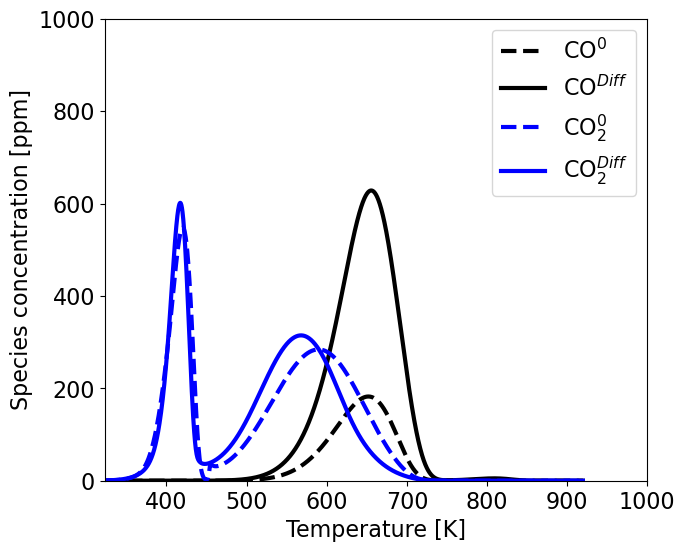

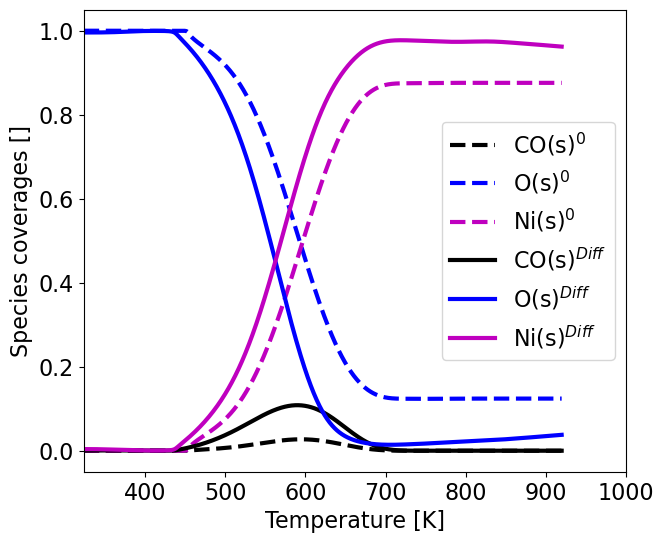

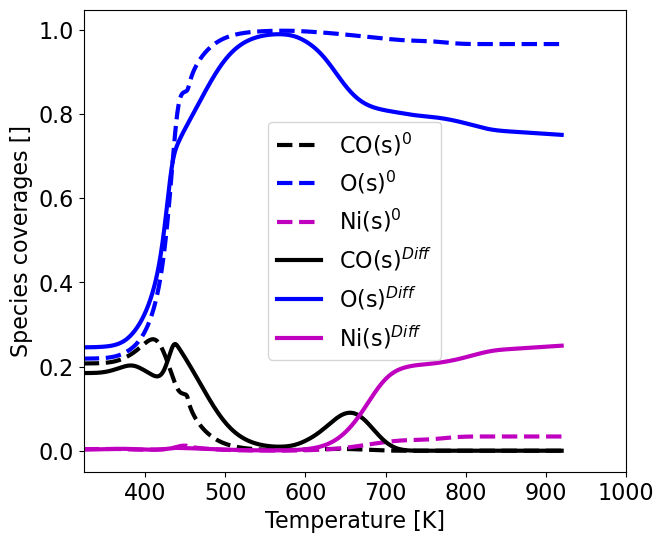

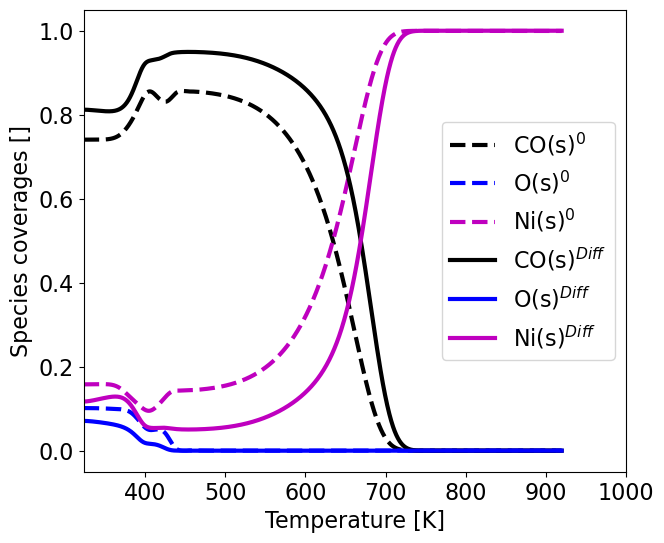

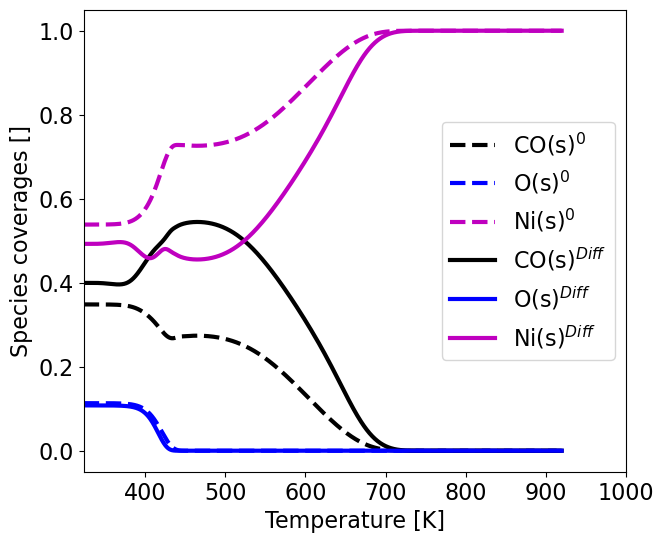

In [36]:
# Plot
plot_gasSpecies(sol0, sol1)

# Plot surface species
plot_surfSpecies(sol0, sol1, sol0.surf_fracs100, sol1.surf_fracs100, 'surf_coverages100.png')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs211, sol1.surf_fracs211, 'surf_coverages211.png')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs110, sol1.surf_fracs110, 'surf_coverages110.png')
plot_surfSpecies(sol0, sol1, sol0.surf_fracs111, sol1.surf_fracs111, 'surf_coverages111.png')

In [50]:
# Comparison with the experimental data
import pandas as pd
filename = 'C:/Users/gkoge/Jupyter notebooks/multifacet/manuscript/TPD_experiments.csv'
#print(filename)
data = pd.read_csv(filename).values
T_expt = data[:,0] + 273.15
co2_expt = data[:,1]
co_expt = data[:,2]

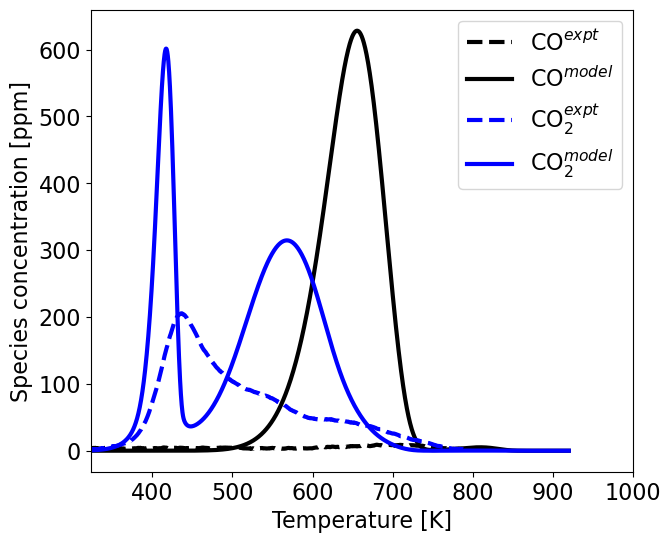

In [52]:
# Plot
plt.rcParams['figure.figsize']=(7,6)
gs = gridspec.GridSpec(1, 1)
plt.rcParams.update({'font.size': 16})
gs.update(wspace = 0.4)
ax0 = plt.subplot(gs[0])
idx = 5410
ax0.plot(T_expt, 1e4*co_expt, label='CO$^{expt}$',color='k', linestyle='dashed', linewidth=3)
ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co,idx:], label='CO$^{model}$',color='k', linewidth=3)
ax0.plot(T_expt, 1e4*co2_expt, label='CO$_2^{expt}$',color='b', linestyle='dashed', linewidth=3)
ax0.plot(sol1.Ti[idx:], 1e6*sol1.gas_mole_fracs[sol1.i_co2,idx:], label='CO$_2^{model}$',color='b', linewidth=3)
ax0.set_xlabel('Temperature [K]')
ax0.set_xlim([323, 1000])
#ax0.set_ylim([0, 1200])
ax0.set_ylabel('Species concentration [ppm]')
ax0.legend()
plt.savefig('gasPhase_expt.png', dpi=300)
plt.show()